In [ ]:
from torch import nn
import numpy as np
import random
import torch
import os
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
    

## Define train and test one epoch functions

In [ ]:
def train_one_epoch(epoch, X, y, model, stepsize, device, criterion):
    # print('\nEpoch: %d' % epoch)
    model.train()
    outputs = model(X)
    ## update SGD step
    loss = criterion(outputs, y)
    curr_loss = loss.item()
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        for param in model.parameters():
            param.data -= stepsize * param.grad
            if not len(param.shape) > 1:
                i += 1
    # print(f'Train loss {mean_train_loss}')
    return curr_loss

def test_one_epoch(epoch, X, y, model, device, criterion):
    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)
    # print(f'Test loss {mean_test_loss}') 
    return loss.item()

## Generate data and runs with different parameters

## Define Simple MLP

 In the following section we generate different sets of gaussian data, with noise added to eigenvectors matching large eigenvalues (only of train set). We examine differenent variations for parameters, for learning rate and sigma (std of noise) we see epoch-wise double descent, on a simple two layer network (as proposed by [Heckel & Yilmaz (2020) ](https://arxiv.org/pdf/2007.10099.pdf))

 **Parameters**: 

N = 100 ## test_size=train_size

D=50

C = 1

n_dense_unit= 250

 

In [ ]:
## hyperparametrs
dense_unit= 250
train_size = 100
test_size = train_size
C= 1
D=50 

def generate_data(sigma=2):
  """ This function generates synthethic datasets as proposed in the paper
  """
  X_train = torch.normal(mean=0, std=1, size=(train_size,D)).t()
  X_test = torch.normal(mean=0, std=1, size=(test_size,D)).t()
  w_real = torch.normal(mean =0,std = 1/np.sqrt(D), size=(C, D))
  sigma = torch.tensor(sigma)

  U_train, S_train, Vt_train =torch.linalg.svd(X_train/np.sqrt(train_size), full_matrices=True)
  U_test, S_test, Vt_test =torch.linalg.svd(X_test/np.sqrt(train_size), full_matrices=True)

  Z_train = torch.zeros((C, train_size))

  for j,s in enumerate(S_train):
      if s>=1:
          for i in range(C):
              Z_train[i][j] = torch.normal(mean =torch.tensor(0), std =sigma, size=(1, ))

  e_train = Z_train@Vt_train
  y_test = w_real @ X_test 
  y_train = w_real @ X_train + e_train
  return X_train.t(), y_train.t(), X_test.t(), y_test.t()

## Generate EDD with different parameters - sigma (amount of noise), and stepsize (learning rate) in order to choose good parametrs for test of EDD

Setup description:

1. We defined a simple  Neural network with 2 layers and one activation function: ReLU
2. Criterions: 
* Train: MSE loss
* Test: L1 mean loss
3. Initialization:
We initiated weights as proposed by Heckel & Yilmaz (2020) - using kaiming_normal initialization. 
4. Training for 50000 epochs



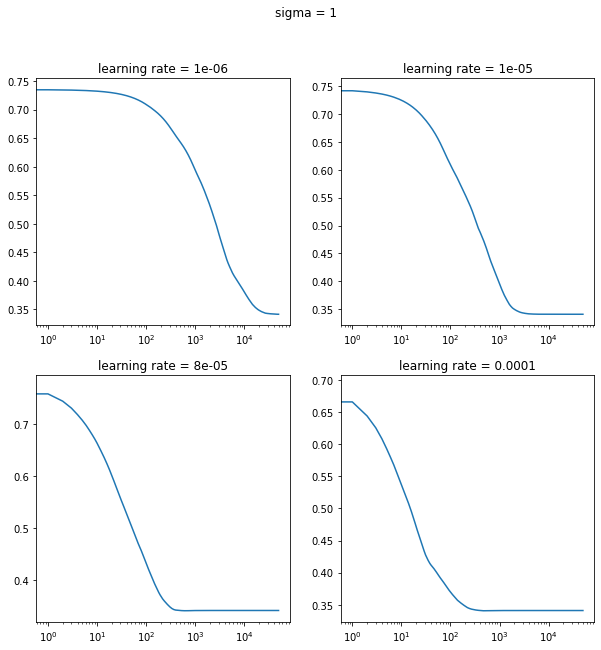

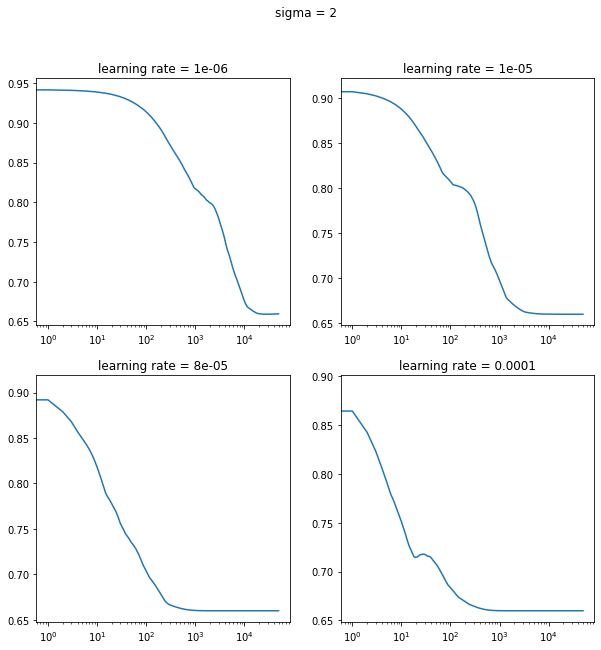

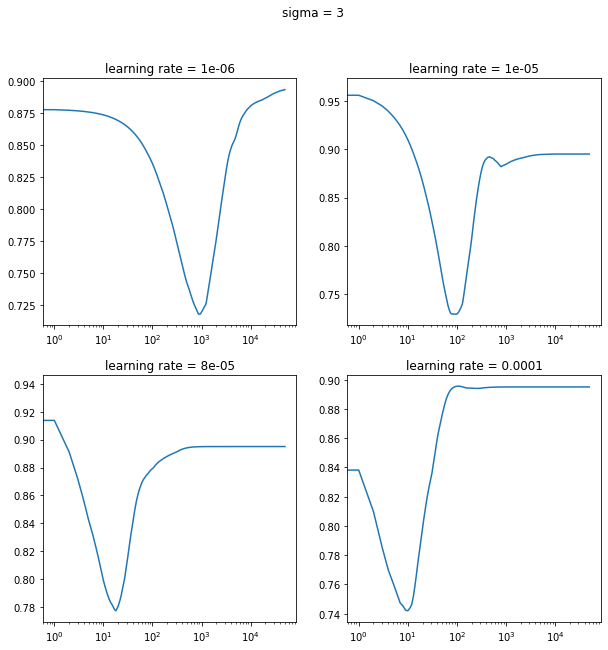

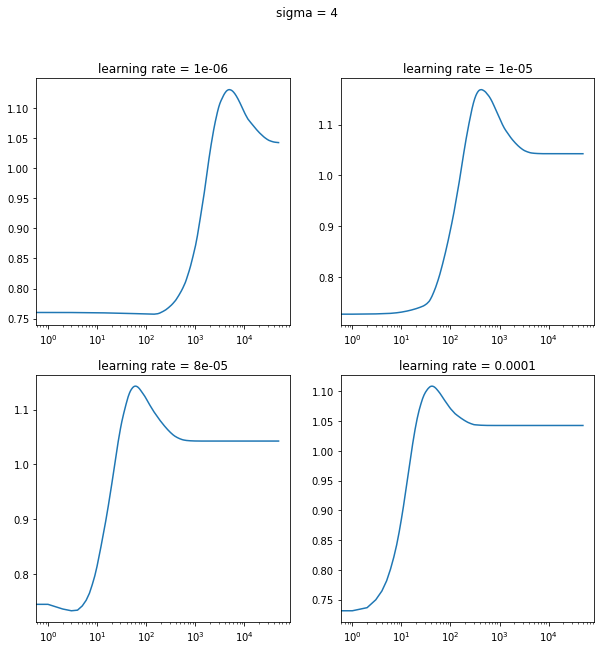

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
  
lr_list = [0.000001, 0.00001,  0.00008, 0.0001]
sigma_list = [1, 2,  3, 4]

TOTAL_EPOCHS=50000
for sigma in sigma_list:
  try:
    X_train = torch.tensor(np.load(f'X_train_sigma={sigma}.npy'))
    y_train = torch.tensor(np.load(f'y_train_sigma={sigma}.npy'))
    X_test = torch.tensor(np.load(f'X_test_sigma={sigma}.npy'))
    y_test = torch.tensor(np.load(f'y_test_sigma={sigma}.npy'))
  except Exception:
    X_train, y_train, X_test, y_test = generate_data(sigma)
    np.save(f'X_train_sigma={sigma}', X_train)
    np.save(f'y_train_sigma={sigma}', y_train)
    np.save(f'X_test_sigma={sigma}', X_test)
    np.save(f'y_test_sigma={sigma}', y_test)

  X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  plt.suptitle(f'sigma = {sigma}')
  for stepsize, ax in zip(lr_list, axes.flatten()):
      model2 = torch.nn.Sequential(
              torch.nn.Linear(D, dense_unit),
              # torch.nn.ReLU(),
              torch.nn.Linear(dense_unit, C)).to(device)

      ## criterion and risk as proposed by both papers
      criterion = torch.nn.MSELoss(reduction='sum').to(device)
      risk_fn = torch.nn.L1Loss(reduction='mean').to(device)

      i = 0
      with torch.no_grad():
          for m in model2:
            ## initiate weights as proposed by Heckel & Yilmaz (2020)
              if type(m) == torch.nn.Linear:
                  if i == 0:
                      torch.nn.init.kaiming_normal_(m.weight, a=np.math.sqrt(5))
                      m.weight.data = torch.mul(m.weight.data, 1)
                  if i == 1:
                      torch.nn.init.kaiming_uniform_(m.weight, a=np.math.sqrt(5))
                      m.weight.data = torch.mul(m.weight.data, 1)
                  i += 1
      train_loss_ordinary, test_loss_ordinary = [], []
      for epoch in range(int(TOTAL_EPOCHS)):
          train_loss = train_one_epoch(epoch, X_train, y_train, model2, stepsize, device, criterion)
          test_loss = test_one_epoch(epoch, X_test, y_test, model2, device, risk_fn)
          train_loss_ordinary.append(train_loss)
          test_loss_ordinary.append(test_loss)

      ax.set_xscale('log')
      ax.plot(test_loss_ordinary, label='test')
      ax.set_title(f'learning rate = {stepsize}')
      np.save(f'test_sigma={sigma}_lr={stepsize}', test_loss_ordinary)
      np.save(f'train_sigma={sigma}_lr={stepsize}', train_loss_ordinary)
  plt.show()

## Plot different results for D=50

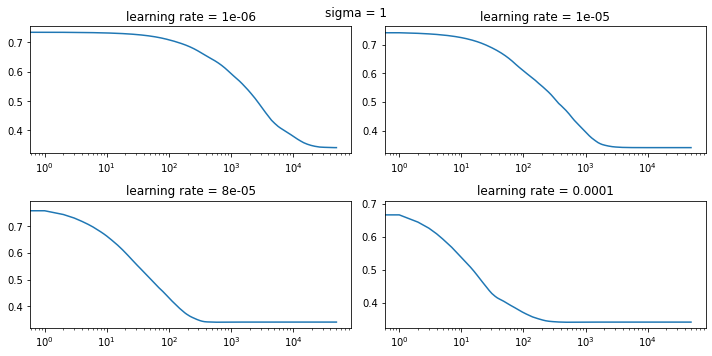

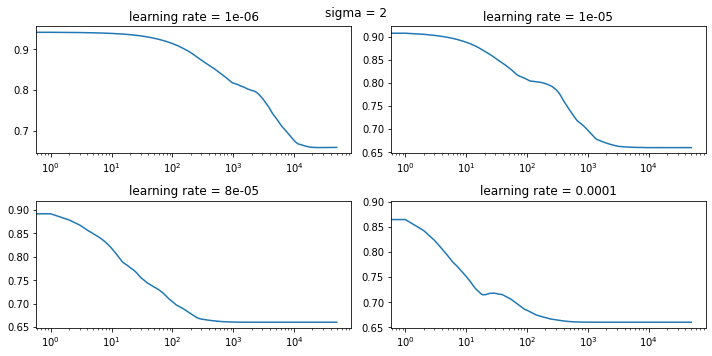

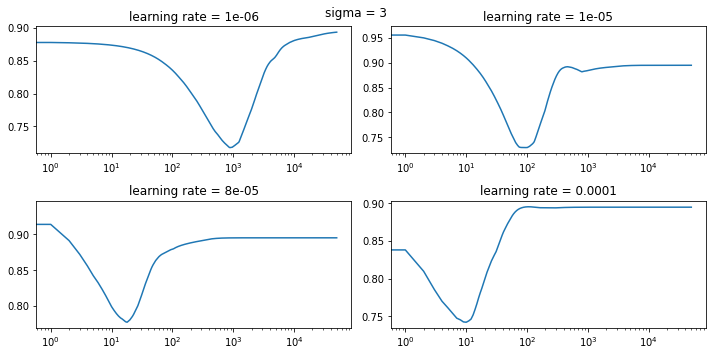

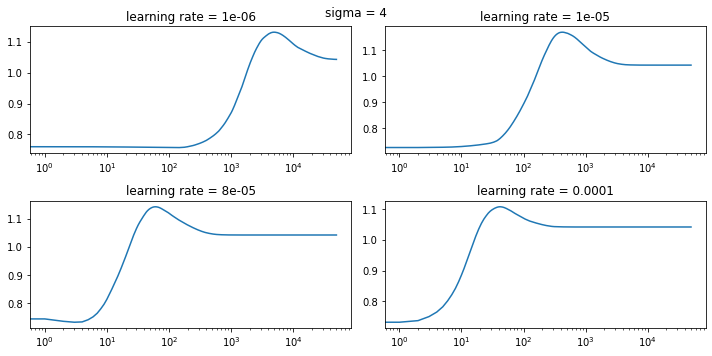

In [ ]:
for sigma in sigma_list:
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
  plt.suptitle(f'sigma = {sigma}')
  for stepsize, ax in zip(lr_list, ax.flatten()):
    ax.set_title(f'learning rate = {stepsize}')
    ax.set_xscale('log')
    test_loss_ordinary = np.load(f'test_sigma={sigma}_lr={stepsize}.npy')
    # np.save(f'train_sigma={sigma}_lr={stepsize}', train_loss_ordinary)
    ax.plot(test_loss_ordinary)
  plt.tight_layout()
  plt.show()

## Results summary:
1. We can see that for small sigma - there is no EDD
2. We can see that according to the paper contributions, there is a critical level of noise (sigma), where epochwise double descent occurs. In our case, it is for sigma = 2.
3. One should also note that in the figures above we see the some tradeoff:

* When there is no noise  (variance = 0), the net learns to fit the data on the test set.

* When there is some noise (variance > 0), the generalization of the train dataset leads to underfitting on the test set. 

## Apply method 2 - update weights with converged weights equation

### STEP 1 - train using standard training for T_EPOCHS (= before EDD)

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
## hyperparametrs
dense_unit= 250
train_size = 100
test_size = train_size
C= 1
D=50 
sigma = 2

net_stand = torch.nn.Sequential(
        torch.nn.Linear(D, dense_unit),
        torch.nn.Linear(dense_unit, C)).to(device)
       
## criterion and risk as proposed by both papers
criterion = torch.nn.MSELoss(reduction='sum').to(device)
risk_fn = torch.nn.L1Loss(reduction='mean').to(device)

i = 0
with torch.no_grad():
    for m in net_stand:
      ## initiate weights as proposed by Heckel & Yilmaz (2020)
        if type(m) == torch.nn.Linear:
            if i == 0:
                torch.nn.init.kaiming_normal_(m.weight, a=np.math.sqrt(5))
                m.weight.data = torch.mul(m.weight.data, 1)
            if i == 1:
                torch.nn.init.kaiming_uniform_(m.weight, a=np.math.sqrt(5))
                m.weight.data = torch.mul(m.weight.data, 1)
            i += 1


train_loss_stand, test_loss_stand = [], []
try:
  X_train = torch.tensor(np.load(f'X_train_sigma={sigma}.npy'))
  y_train = torch.tensor(np.load(f'y_train_sigma={sigma}.npy'))
  X_test = torch.tensor(np.load(f'X_test_sigma={sigma}.npy'))
  y_test = torch.tensor(np.load(f'y_test_sigma={sigma}.npy'))
  print('loading original data...')
except Exception:
  X_train, y_train, X_test, y_test = generate_data(sigma)
  np.save(f'X_train_sigma={sigma}', X_train)
  np.save(f'y_train_sigma={sigma}', y_train)
  np.save(f'X_test_sigma={sigma}', X_test)
  np.save(f'y_test_sigma={sigma}', y_test)
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

## train for t epochs as standard training procedere
stepsize = 0.00005
T_EPOCHS = 10
TOTAL_EPOCHS = 50000
for epoch in range(TOTAL_EPOCHS):
    train = train_one_epoch(epoch, X_train, y_train, net_stand, stepsize, device, criterion)
    test = test_one_epoch(epoch, X_test, y_test, net_stand, device, risk_fn)
    train_loss_stand.append(train)
    test_loss_stand.append(test)
    if epoch == T_EPOCHS:
      PATH = f"model_epoch={T_EPOCHS}.pt"
      torch.save({
                'epoch': T_EPOCHS,
                'model_state_dict': net_stand.state_dict(),
                }, PATH)

loading original data...


### plot standard training test risk - making sure that EDD occurs

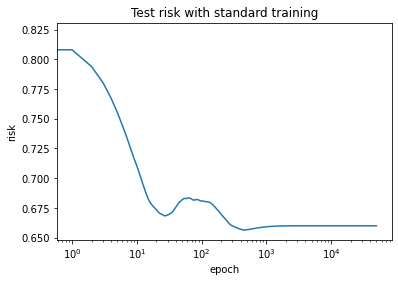

In [190]:
plt.plot(test_loss_stand)
plt.xscale('log')
plt.title('Test risk with standard training')
plt.xlabel('epoch')
plt.ylabel('risk')

plt.show()

## Compute theortical equation for 'converged weights'

## Define functions for computation of analytical solution 

In [205]:
## define lambda.T @ lambda as in definition above equation 19 (page 12)

def define_Z(S_phi,eps):
    Z = torch.zeros((S_phi.shape[0], S_phi.shape[0]))
    for i in range(S_phi.shape[0]):
        if S_phi[i] > eps:
            Z[i,i] = torch.tensor(1)
    return Z


def define_M(C=1):
    M = torch.eye(n=C) - (1/C)*torch.ones((C,C))
    return M

def define_P_l(N, C, y):
    P_l = torch.zeros(size=(C,N))
    Y = y
    for i, col in enumerate(Y):
        j = torch.argmax(col)
        P_l[j][i] = torch.tensor(1)

    return P_l

def solver_inf(M, w_0, P_l, C, D, N, phi, Z, U, F, y ='None', loss='ce'):
    pseudo_phi = torch.inverse(phi.t() @ phi)
    eye = torch.eye(F)
    if loss == 'ce':
        ones_cn = torch.ones(C, N)
        eq1 = M @ (C* P_l - ones_cn) @ phi.t() @ pseudo_phi
        eq2 = M @ w_0 @ (eye - U @ Z @ U.t())
    else:
        eq1 = y.t() @ phi @ pseudo_phi
        eq2 = w_0 @ (eye - U @ Z @ U.t())

    return eq1+eq2

def solver_t(w_inf, w_0, U, Lambda, t, F, gamma):
    mat = torch.eye(F) - gamma * Lambda
    mat_pow = np.linalg.matrix_power(mat, t)
    eq1 = w_inf + (w_0 - w_inf)@ U @ mat_pow @ U.t()
    return eq1

## Load model trained for T_EPOCHS(=10) and replace weights

In [210]:
net_conv = torch.nn.Sequential(
        torch.nn.Linear(D, dense_unit),
        torch.nn.Linear(dense_unit, C))

PATH = f"model_epoch={T_EPOCHS}.pt"
checkpoint = torch.load(PATH)
net_conv.load_state_dict(checkpoint['model_state_dict'])

layer1_weights = net_conv[1].weight.detach()
X_train, y_train, X_test, y_test = X_train.detach(), y_train.detach(), X_test.detach(), y_test.detach()


phi = net_conv[0](X_train).detach()

U_phi, S_phi, Vt_phi = torch.linalg.svd((phi.t() @ phi )/(train_size), full_matrices=True)

t = T_EPOCHS
F = U_phi.shape[0]

gamma = torch.tensor(stepsize)

M = define_M(C=C)
P_l = define_P_l(train_size,C, y=y_train)
eps = 1e-5
Z = define_Z(S_phi, eps)
w_inf = solver_inf(M, layer1_weights, P_l, C, D, train_size, phi, Z, U_phi, F, y =y_train, loss='mse')
w_t = solver_t(w_inf, layer1_weights, U_phi, S_phi, t, F, gamma)
with torch.no_grad():
  net_conv[1].weight.data =  torch.nn.Parameter(w_t)


In [211]:
##rerun with modified weights
TOTAL_EPOCHS = 50000 
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)
net_conv = net_conv.to(device)
train_loss_convereged, test_loss_convereged = [], []
for epoch in range(0,TOTAL_EPOCHS):
    train = train_one_epoch(epoch, X_train, y_train, net_conv, stepsize, device, criterion)
    test = test_one_epoch(epoch, X_test, y_test, net_conv, device, risk_fn)
    train_loss_convereged.append(train)
    test_loss_convereged.append(test)


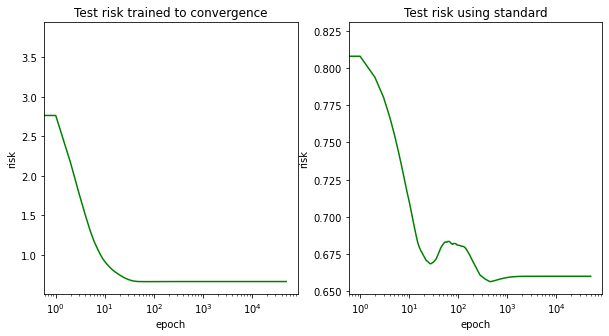

In [212]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize= (10, 5))

axes[0].plot(test_loss_convereged, c = 'green')
axes[0].set_title('Test risk trained to convergence')
axes[0].set_xscale('log')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('risk')


axes[1].plot(test_loss_stand, c = 'green')
axes[1].set_title('Test risk using standard')
axes[1].set_xscale('log')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('risk')


plt.show()

In [200]:
print(f'standard training min :{min(test_loss_stand)}')
print(f'converged training min :{min(test_loss_convereged)}')

standard training min :0.6563124060630798
converged training min :0.6585173606872559
